In [1]:
BATCH_SIZE = 32
MAX_LEN = 716
EMBEDDING_DIMS = 300
NUM_CLASSES = 9
NUM_TRAIN = 5893
NUM_TEST = 1474

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN], dtype=tf.float32),
            'Y': tf.FixedLenFeature((NUM_CLASSES,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN])
    
    return X, Y

In [4]:
%%time

x_train, y_train = iterator('train_with_sp.tfrecord', NUM_TRAIN)
x_test, y_test = iterator('test_with_sp.tfrecord', NUM_TEST)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 2.2 s, sys: 1.28 s, total: 3.48 s
Wall time: 2.52 s


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 716), (5893, 9), (1474, 716), (1474, 9))

In [6]:
hidden_dims = 50
epochs = 5

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, CuDNNLSTM, Flatten
from keras.layers.wrappers import Bidirectional

model = Sequential()
model.add(Embedding(8001, EMBEDDING_DIMS, input_length=MAX_LEN))
model.add(Bidirectional(CuDNNLSTM(hidden_dims, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 716, 300)          2400300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 716, 100)          140800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 716, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 71600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 644409    
Total params: 3,185,509
Trainable params: 3,185,509
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [11]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/5
5893/5893 [==============================] - 27s 5ms/step - loss: 0.6551 - acc: 0.7748 - val_loss: 0.2374 - val_acc: 0.9199
Epoch 2/5
5893/5893 [==============================] - 25s 4ms/step - loss: 0.0541 - acc: 0.9844 - val_loss: 0.2452 - val_acc: 0.9240
Epoch 3/5
5893/5893 [==============================] - 25s 4ms/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.2198 - val_acc: 0.9396
Epoch 4/5
5893/5893 [==============================] - 24s 4ms/step - loss: 9.5059e-04 - acc: 0.9998 - val_loss: 0.2418 - val_acc: 0.9383
Epoch 5/5
5893/5893 [==============================] - 24s 4ms/step - loss: 3.1786e-04 - acc: 1.0000 - val_loss: 0.2430 - val_acc: 0.9403
CPU times: user 2min 4s, sys: 11.6 s, total: 2min 16s
Wall time: 2min 7s


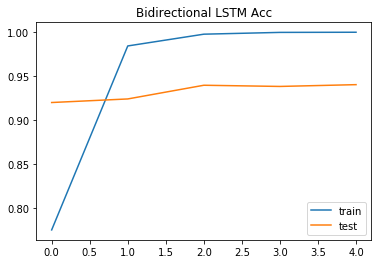

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Bidirectional LSTM Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

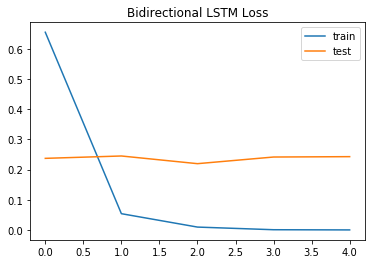

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.927     0.943     0.935       175
  it-life-hack      0.936     0.955     0.945       154
 kaden-channel      0.970     0.964     0.967       167
livedoor-homme      0.930     0.702     0.800       114
   movie-enter      0.919     0.983     0.950       174
        peachy      0.891     0.935     0.912       184
          smax      0.969     0.995     0.981       186
  sports-watch      0.969     0.957     0.963       163
    topic-news      0.955     0.949     0.952       157

     micro avg      0.940     0.940     0.940      1474
     macro avg      0.941     0.931     0.934      1474
  weighted avg      0.941     0.940     0.939      1474



Normalized confusion matrix
[[0.943 0.    0.    0.017 0.006 0.034 0.    0.    0.   ]
 [0.    0.955 0.006 0.    0.    0.013 0.019 0.    0.006]
 [0.    0.012 0.964 0.006 0.    0.012 0.006 0.    0.   ]
 [0.035 0.053 0.026 0.702 0.079 0.079 0.    0.018 0.009]
 [0.006 0.    0.    0.    0.983 0.011 0.    0.    0.   ]
 [0.043 0.005 0.005 0.    0.011 0.935 0.    0.    0.   ]
 [0.    0.005 0.    0.    0.    0.    0.995 0.    0.   ]
 [0.    0.    0.    0.006 0.    0.    0.006 0.957 0.031]
 [0.    0.    0.    0.006 0.019 0.    0.006 0.019 0.949]]


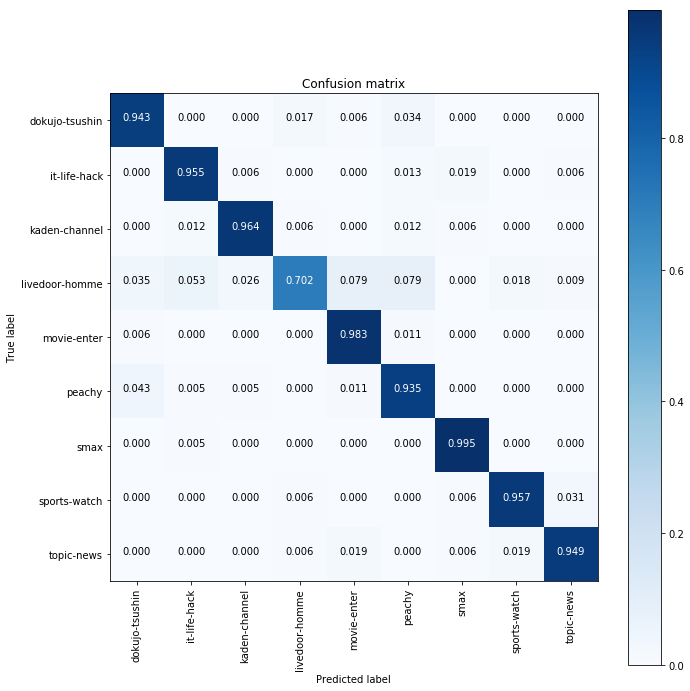

In [16]:
import sys
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)